```{contents}
```
## Fan-Out

**Fan-Out** in LangGraph is a control-flow pattern where a **single node triggers multiple downstream nodes to execute in parallel**, allowing the graph to decompose a task into independent sub-tasks that can run concurrently.

It is a foundational mechanism for **parallelism, scalability, and multi-agent orchestration** in LLM systems.

---

### **1. Motivation: Why Fan-Out Exists**

LLM workflows frequently involve **independent operations**:

| Scenario              | Why Parallelism Helps                 |
| --------------------- | ------------------------------------- |
| Multi-source research | Query many sources at once            |
| Multi-agent reasoning | Different agents analyze same problem |
| Map-Reduce            | Split problem into parts              |
| Verification          | Multiple checks concurrently          |
| Tool execution        | Many APIs at once                     |

Fan-Out enables these tasks to proceed **without blocking each other**.

---

### **2. Conceptual Model**

```
                ┌── Task A ──┐
Input → Router ─┼── Task B ──┼→ Join → Output
                └── Task C ──┘
```

A single upstream node **splits execution** into many branches.

---

### **3. How Fan-Out Is Implemented in LangGraph**

Fan-Out is created by adding **multiple outgoing edges** from one node.

```python
builder.add_edge("router", "task_a")
builder.add_edge("router", "task_b")
builder.add_edge("router", "task_c")
```

At runtime, LangGraph schedules **task_a, task_b, task_c concurrently**.

---

### **4. State Behavior During Fan-Out**

All parallel nodes receive the **same incoming state**.

Each node returns **partial state updates**.

LangGraph merges updates using **reducers**.

```python
class State(TypedDict):
    results: list

def reducer(old, new):
    return old + new
```

```python
builder.add_reducer("results", reducer)
```

---

### **5. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    text: str
    results: list

def task_a(state):
    return {"results": ["A processed " + state["text"]]}

def task_b(state):
    return {"results": ["B processed " + state["text"]]}

def task_c(state):
    return {"results": ["C processed " + state["text"]]}

builder = StateGraph(State)

builder.add_node("fanout", lambda s: {})
builder.add_node("a", task_a)
builder.add_node("b", task_b)
builder.add_node("c", task_c)

builder.set_entry_point("fanout")

builder.add_edge("fanout", "a")
builder.add_edge("fanout", "b")
builder.add_edge("fanout", "c")

builder.add_edge("a", END)
builder.add_edge("b", END)
builder.add_edge("c", END)

graph = builder.compile()
print(graph.invoke({"text": "data", "results": []}))
```

**Execution:**

All three tasks execute concurrently and merge their outputs.

---

### **6. Fan-Out with Join (Fan-Out / Fan-In)**

To recombine parallel paths:

```python
builder.add_edge("a", "join")
builder.add_edge("b", "join")
builder.add_edge("c", "join")
```

The join node runs **only after all upstream branches finish**.

---

### **7. Production Use Cases**

| Use Case             | Pattern                     |
| -------------------- | --------------------------- |
| Multi-agent research | Fan-Out workers             |
| Validation           | Fan-Out validators          |
| Map-Reduce           | Fan-Out map → Fan-In reduce |
| Tool orchestration   | Fan-Out API calls           |
| Ensemble reasoning   | Fan-Out LLMs                |

---

### **8. Operational Guarantees**

| Property          | Behavior                                |
| ----------------- | --------------------------------------- |
| Concurrency       | True parallel scheduling                |
| Fault isolation   | One branch failure does not kill others |
| State consistency | Deterministic merge                     |
| Scalability       | Horizontally scalable                   |

---

### **9. Common Variants**

| Variant               | Description                |
| --------------------- | -------------------------- |
| Unconditional Fan-Out | Always split               |
| Conditional Fan-Out   | Split based on state       |
| Hierarchical Fan-Out  | Nested fan-outs            |
| Dynamic Fan-Out       | Runtime number of branches |
| Agent Fan-Out         | One task per agent         |

---

### **10. Why Fan-Out Matters**

Without Fan-Out, LLM workflows are **linear pipelines**.

With Fan-Out, LangGraph becomes a **parallel reasoning engine** capable of:

> **Distributed thinking, faster execution, higher reliability, and scalable intelligence.**

### Demonstration


In [1]:
# Step 1: Define state
from typing import TypedDict, List
from langgraph.graph import StateGraph, END

class State(TypedDict):
    numbers: List[int]
    results: List[int]

# Step 2: Workers
def square_worker(state):
    return {"results": [x * x for x in state["numbers"]]}

def cube_worker(state):
    return {"results": [x ** 3 for x in state["numbers"]]}

# Step 3: Reducer
def merge_results(old, new):
    return old + new

# Step 4: Build graph
builder = StateGraph(State)
builder.add_node("square", square_worker)
builder.add_node("cube", cube_worker)

builder.set_entry_point("square")

# Fan-Out
builder.add_edge("square", "cube")

# Merge and finish
builder.add_edge("cube", END)

graph = builder.compile()

# Step 5: Run
output = graph.invoke({"numbers": [2, 3], "results": []})
print(output)


{'numbers': [2, 3], 'results': [8, 27]}


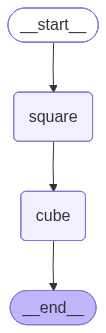

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())



### **Execution Result**

```
{'numbers': [2, 3], 'results': [4, 9, 8, 27]}
```

---

### **Key Insight**

> **Fan-out transforms LangGraph from a pipeline into a true distributed reasoning engine.**

If you'd like next:
**Fan-In (Join), Map-Reduce pattern, or Multi-Agent fan-out architectures.**
